In [11]:
# Análise de Drawdown com Simulação Monte Carlo
# Versão simplificada focada em análise de risco para Jupyter Notebook

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuração de estilo
plt.style.use('default')
sns.set_palette("husl")

def load_stock_data(ticker, start_date="2018-01-01", end_date=None):
    """Carrega dados históricos do ativo"""
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    
    print(f"📊 Carregando dados para {ticker}...")
    
    data = yf.download(ticker, start_date, end_date, progress=False, auto_adjust=False)
    
    if data.empty:
        raise ValueError(f"Nenhum dado encontrado para {ticker}")
    
    # Se dados têm múltiplos níveis de coluna, simplifica
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    
    print(f"✅ {len(data)} observações carregadas ({data.index[0].strftime('%Y-%m-%d')} até {data.index[-1].strftime('%Y-%m-%d')})")
    return data

def calculate_simple_strategy_returns(data, strategy='buy_hold'):
    """
    Calcula retornos de estratégias simples
    Estratégias disponíveis: 'buy_hold', 'ma_cross', 'rsi_reversal'
    """
    
    if strategy == 'buy_hold':
        # Buy and Hold - sempre comprado
        returns = data['Adj Close'].pct_change().dropna()
        
    elif strategy == 'ma_cross':
        # Cruzamento de médias móveis (20 e 50 períodos)
        short_ma = data['Adj Close'].rolling(20).mean()
        long_ma = data['Adj Close'].rolling(50).mean()
        
        # Sinal: 1 quando MA curta > MA longa, 0 caso contrário
        signals = (short_ma > long_ma).astype(int)
        positions = signals.shift(1).fillna(0)  # Executa no próximo dia
        
        market_returns = data['Adj Close'].pct_change()
        returns = (positions * market_returns).dropna()
        
    elif strategy == 'rsi_reversal':
        # RSI Reversal (compra oversold, vende overbought)
        delta = data['Adj Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        # Sinais: compra quando RSI < 30, vende quando RSI > 70
        signals = pd.Series(0, index=data.index)
        signals[rsi < 30] = 1  # Compra
        signals[rsi > 70] = 0  # Vende
        
        # Forward fill para manter posições
        signals = signals.replace(0, np.nan).fillna(method='ffill').fillna(0)
        positions = signals.shift(1).fillna(0)
        
        market_returns = data['Adj Close'].pct_change()
        returns = (positions * market_returns).dropna()
    
    else:
        raise ValueError("Estratégia deve ser: 'buy_hold', 'ma_cross', ou 'rsi_reversal'")
    
    return returns

def calculate_historical_drawdown(returns):
    """Calcula drawdown histórico dos retornos"""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    return drawdown, drawdown.min()

def monte_carlo_drawdown_simulation(returns, years=3, num_simulations=10000, initial_value=100000):
    """
    Executa simulação Monte Carlo para prever drawdowns futuros
    
    Parâmetros:
    - returns: série histórica de retornos
    - years: número de anos para simular
    - num_simulations: número de simulações
    - initial_value: valor inicial da carteira
    """
    
    print(f"🎲 Iniciando Monte Carlo...")
    print(f"   • {num_simulations:,} simulações")
    print(f"   • {years} anos futuros")
    print(f"   • Valor inicial: R$ {initial_value:,.0f}")
    
    # Remove NaN e zeros dos retornos históricos
    clean_returns = returns.dropna()
    clean_returns = clean_returns[clean_returns != 0]
    
    if len(clean_returns) < 50:
        raise ValueError(f"Poucos retornos históricos válidos: {len(clean_returns)}")
    
    num_days = years * 252  # Dias úteis por ano
    max_drawdowns = np.zeros(num_simulations)
    final_values = np.zeros(num_simulations)
    
    # Estatísticas dos retornos históricos
    mean_return = clean_returns.mean()
    std_return = clean_returns.std()
    
    print(f"   • Retorno médio diário: {mean_return*100:.3f}%")
    print(f"   • Volatilidade diária: {std_return*100:.3f}%")
    
    for i in range(num_simulations):
        # Método 1: Bootstrap (reamostragem dos retornos históricos)
        simulated_returns = np.random.choice(clean_returns.values, size=num_days, replace=True)
        
        # Método 2: Distribuição normal (descomente para usar)
        # simulated_returns = np.random.normal(mean_return, std_return, num_days)
        
        # Calcula valores da carteira
        portfolio_values = initial_value * np.cumprod(1 + simulated_returns)
        
        # Calcula drawdown máximo da simulação
        running_max = np.maximum.accumulate(portfolio_values)
        drawdowns = (running_max - portfolio_values) / running_max
        max_drawdown = np.max(drawdowns)
        
        max_drawdowns[i] = max_drawdown
        final_values[i] = portfolio_values[-1]
        
        # Progress indicator
        if (i + 1) % (num_simulations // 10) == 0:
            print(f"   • Progresso: {(i+1)/num_simulations*100:.0f}%")
    
    print("✅ Simulação concluída!")
    
    return max_drawdowns, final_values

def plot_drawdown_analysis(max_drawdowns, ticker, strategy_name):
    """Plota análise completa dos drawdowns simulados"""
    
    dd_pct = max_drawdowns * 100
    
    # Cria figura com subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Distribuição dos Drawdowns', 'Box Plot', 
                       'Probabilidades Acumuladas', 'Cenários de Risco'),
        specs=[[{"type": "histogram"}, {"type": "box"}],
               [{"type": "scatter"}, {"type": "bar"}]]
    )
    
    # 1. Histograma
    fig.add_trace(
        go.Histogram(x=dd_pct, nbinsx=50, name="Drawdowns", 
                    marker_color='rgba(231, 76, 60, 0.7)'),
        row=1, col=1
    )
    
    # 2. Box Plot
    fig.add_trace(
        go.Box(y=dd_pct, name="Drawdowns", marker_color='rgba(52, 152, 219, 0.7)'),
        row=1, col=2
    )
    
    # 3. Distribuição Acumulada
    sorted_dd = np.sort(dd_pct)
    probabilities = np.arange(1, len(sorted_dd) + 1) / len(sorted_dd) * 100
    
    fig.add_trace(
        go.Scatter(x=sorted_dd, y=probabilities, mode='lines',
                  name='CDF', line=dict(color='green', width=2)),
        row=2, col=1
    )
    
    # 4. Cenários de Risco (percentis)
    percentiles = [50, 75, 90, 95, 99]
    values = np.percentile(dd_pct, percentiles)
    
    fig.add_trace(
        go.Bar(x=[f'P{p}' for p in percentiles], y=values,
              name='Percentis', marker_color='rgba(155, 89, 182, 0.7)'),
        row=2, col=2
    )
    
    # Layout
    fig.update_layout(
        title=f'📊 Análise Monte Carlo - Drawdowns Futuros<br>{ticker} ({strategy_name})',
        height=800,
        showlegend=False
    )
    
    fig.update_xaxes(title_text="Drawdown Máximo (%)", row=1, col=1)
    fig.update_xaxes(title_text="Drawdown Máximo (%)", row=2, col=1)
    fig.update_xaxes(title_text="Percentil", row=2, col=2)
    
    fig.update_yaxes(title_text="Frequência", row=1, col=1)
    fig.update_yaxes(title_text="Drawdown (%)", row=1, col=2)
    fig.update_yaxes(title_text="Probabilidade (%)", row=2, col=1)
    fig.update_yaxes(title_text="Drawdown (%)", row=2, col=2)
    
    fig.show()

def generate_risk_report(max_drawdowns, final_values, ticker, strategy_name, initial_value=100000):
    """Gera relatório detalhado de risco"""
    
    dd_pct = max_drawdowns * 100
    
    print("=" * 80)
    print(f"📊 RELATÓRIO DE RISCO MONTE CARLO")
    print(f"🎯 Ativo: {ticker} | Estratégia: {strategy_name}")
    print("=" * 80)
    
    # Estatísticas básicas dos drawdowns
    print(f"📈 ESTATÍSTICAS DOS DRAWDOWNS FUTUROS (3 anos):")
    print(f"   • Drawdown médio esperado: {np.mean(dd_pct):.2f}%")
    print(f"   • Drawdown mediano: {np.median(dd_pct):.2f}%")
    print(f"   • Desvio padrão: {np.std(dd_pct):.2f}%")
    print(f"   • Mínimo (melhor caso): {np.min(dd_pct):.2f}%")
    print(f"   • Máximo (pior caso): {np.max(dd_pct):.2f}%")
    
    # Cenários de risco
    print(f"\n⚠️  CENÁRIOS DE RISCO (Probabilidade de EXCEDER):")
    risk_levels = [
        (50, "médio"),
        (75, "conservador"), 
        (90, "muito conservador"),
        (95, "extremamente conservador"),
        (99, "catastrófico")
    ]
    
    for percentile, description in risk_levels:
        value = np.percentile(dd_pct, percentile)
        prob = 100 - percentile
        print(f"   • {prob:2d}% chance de DD > {value:6.2f}% (cenário {description})")
    
    # Classificação de risco
    median_dd = np.median(dd_pct)
    p95_dd = np.percentile(dd_pct, 95)
    
    if median_dd < 15 and p95_dd < 35:
        risk_class = "🟢 BAIXO"
        risk_desc = "Drawdowns moderados esperados"
    elif median_dd < 25 and p95_dd < 50:
        risk_class = "🟡 MÉDIO"  
        risk_desc = "Drawdowns significativos possíveis"
    else:
        risk_class = "🔴 ALTO"
        risk_desc = "Drawdowns severos prováveis"
    
    print(f"\n🏷️  CLASSIFICAÇÃO DE RISCO: {risk_class}")
    print(f"   • {risk_desc}")
    
    # Análise de retornos finais
    final_returns = (final_values / initial_value - 1) * 100
    positive_scenarios = (final_values > initial_value).mean() * 100
    
    print(f"\n💰 ANÁLISE DE RETORNOS (3 anos):")
    print(f"   • Probabilidade de lucro: {positive_scenarios:.1f}%")
    print(f"   • Retorno médio esperado: {np.mean(final_returns):.2f}%")
    print(f"   • Retorno mediano: {np.median(final_returns):.2f}%")
    print(f"   • Melhor cenário (P5): +{np.percentile(final_returns, 95):.2f}%")
    print(f"   • Pior cenário (P95): {np.percentile(final_returns, 5):.2f}%")
    
    print("=" * 80)
    
    return {
        'median_drawdown': np.median(dd_pct),
        'p95_drawdown': np.percentile(dd_pct, 95),
        'mean_return': np.mean(final_returns),
        'prob_profit': positive_scenarios,
        'risk_classification': risk_class
    }

def plot_equity_curve_with_drawdown(data, returns, ticker, strategy_name):
    """Plota curva de equity histórica com drawdown"""
    
    # Calcula equity curve
    equity = (1 + returns).cumprod() * 100000  # Valor inicial de R$ 100k
    
    # Calcula drawdown histórico
    drawdown, max_dd = calculate_historical_drawdown(returns)
    drawdown_pct = drawdown * 100
    
    # Cria subplot
    fig = make_subplots(
        rows=2, cols=1,
        subplot_titles=(f'Evolução da Carteira - {ticker} ({strategy_name})', 
                       'Drawdown Histórico'),
        vertical_spacing=0.1,
        row_heights=[0.7, 0.3]
    )
    
    # Equity curve
    fig.add_trace(
        go.Scatter(x=equity.index, y=equity.values, 
                  mode='lines', name='Valor da Carteira',
                  line=dict(color='blue', width=2)),
        row=1, col=1
    )
    
    # Drawdown
    fig.add_trace(
        go.Scatter(x=drawdown_pct.index, y=drawdown_pct.values,
                  mode='lines', name='Drawdown',
                  fill='tonexty', fillcolor='rgba(255, 0, 0, 0.3)',
                  line=dict(color='red', width=1)),
        row=2, col=1
    )
    
    # Layout
    fig.update_layout(
        title=f'📈 Análise Histórica - {ticker}',
        height=600,
        showlegend=False
    )
    
    fig.update_yaxes(title_text="Valor (R$)", row=1, col=1)
    fig.update_yaxes(title_text="Drawdown (%)", row=2, col=1)
    fig.update_xaxes(title_text="Data", row=2, col=1)
    
    # Adiciona anotação do drawdown máximo
    fig.add_annotation(
        x=0.02, y=0.95,
        xref="paper", yref="paper",
        text=f"DD Máximo Histórico: {abs(max_dd)*100:.2f}%",
        showarrow=False,
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="red",
        borderwidth=1
    )
    
    fig.show()

# ================================
# EXEMPLO DE USO COMPLETO
# ================================

def run_complete_drawdown_analysis(ticker, strategy='buy_hold', start_date="2018-01-01"):
    """
    Executa análise completa de drawdown para um ativo
    """
    
    print(f"🚀 INICIANDO ANÁLISE COMPLETA DE DRAWDOWN")
    print(f"📊 Ativo: {ticker}")
    print(f"📈 Estratégia: {strategy}")
    print("=" * 60)
    
    # 1. Carrega dados
    data = load_stock_data(ticker, start_date)
    
    # 2. Calcula retornos da estratégia
    returns = calculate_simple_strategy_returns(data, strategy)
    print(f"✅ Retornos calculados: {len(returns)} observações")
    
    # 3. Análise histórica
    historical_dd, max_historical_dd = calculate_historical_drawdown(returns)
    print(f"📉 Drawdown máximo histórico: {abs(max_historical_dd)*100:.2f}%")
    
    # 4. Plota histórico
    plot_equity_curve_with_drawdown(data, returns, ticker, strategy)
    
    # 5. Monte Carlo
    max_drawdowns, final_values = monte_carlo_drawdown_simulation(
        returns, years=3, num_simulations=10000
    )
    
    # 6. Visualizações
    plot_drawdown_analysis(max_drawdowns, ticker, strategy)
    
    # 7. Relatório final
    risk_metrics = generate_risk_report(
        max_drawdowns, final_values, ticker, strategy
    )
    
    return {
        'returns': returns,
        'historical_drawdown': historical_dd,
        'max_historical_dd': max_historical_dd,
        'simulated_drawdowns': max_drawdowns,
        'final_values': final_values,
        'risk_metrics': risk_metrics
    }

# Exemplo de execução
if __name__ == "__main__":
    # Análise para IBOVESPA
    results = run_complete_drawdown_analysis("BOVA11.SA", strategy='ma_cross')
    
    # Análise para uma ação individual  
    # results = run_complete_drawdown_analysis("PETR4.SA", strategy='ma_cross')

🚀 INICIANDO ANÁLISE COMPLETA DE DRAWDOWN
📊 Ativo: BOVA11.SA
📈 Estratégia: ma_cross
📊 Carregando dados para BOVA11.SA...
✅ 1823 observações carregadas (2018-01-02 até 2025-06-02)
✅ Retornos calculados: 1822 observações
📉 Drawdown máximo histórico: 17.74%


🎲 Iniciando Monte Carlo...
   • 10,000 simulações
   • 3 anos futuros
   • Valor inicial: R$ 100,000
   • Retorno médio diário: 0.083%
   • Volatilidade diária: 1.244%
   • Progresso: 10%
   • Progresso: 20%
   • Progresso: 30%
   • Progresso: 40%
   • Progresso: 50%
   • Progresso: 60%
   • Progresso: 70%
   • Progresso: 80%
   • Progresso: 90%
   • Progresso: 100%
✅ Simulação concluída!


📊 RELATÓRIO DE RISCO MONTE CARLO
🎯 Ativo: BOVA11.SA | Estratégia: ma_cross
📈 ESTATÍSTICAS DOS DRAWDOWNS FUTUROS (3 anos):
   • Drawdown médio esperado: 21.95%
   • Drawdown mediano: 20.70%
   • Desvio padrão: 6.93%
   • Mínimo (melhor caso): 7.43%
   • Máximo (pior caso): 63.38%

⚠️  CENÁRIOS DE RISCO (Probabilidade de EXCEDER):
   • 50% chance de DD >  20.70% (cenário médio)
   • 25% chance de DD >  25.74% (cenário conservador)
   • 10% chance de DD >  31.34% (cenário muito conservador)
   •  5% chance de DD >  35.27% (cenário extremamente conservador)
   •  1% chance de DD >  43.00% (cenário catastrófico)

🏷️  CLASSIFICAÇÃO DE RISCO: 🟡 MÉDIO
   • Drawdowns significativos possíveis

💰 ANÁLISE DE RETORNOS (3 anos):
   • Probabilidade de lucro: 95.4%
   • Retorno médio esperado: 87.14%
   • Retorno mediano: 76.92%
   • Melhor cenário (P5): +207.65%
   • Pior cenário (P95): 1.33%


In [ ]:
# Carregando as bibliotecas

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf

[*********************100%***********************]  1 of 1 completed


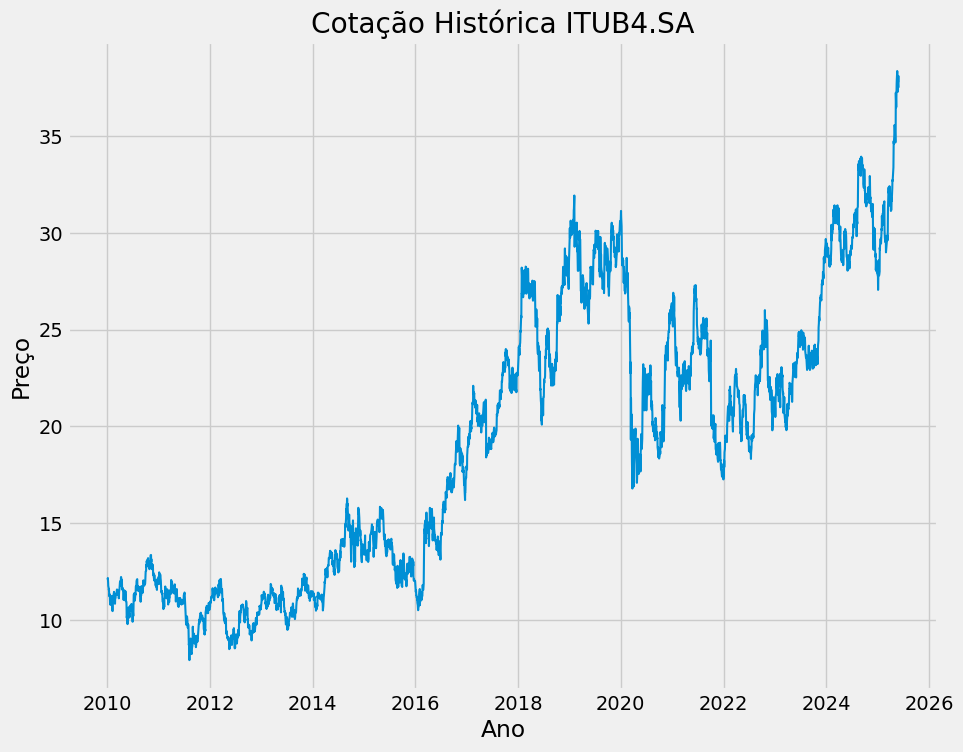

In [14]:
# Carregando a base de dados e fazendo os checks iniciais

plt.style.use("fivethirtyeight")

# Carrega a base
ticker = "ITUB4.SA"
inicio = "2010-01-01"
fim = datetime.today().strftime("%Y-%m-%d")
df1 = yf.download(ticker, inicio, fim, auto_adjust=False)
df1.columns=df1.columns.get_level_values(0)

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(df1["Adj Close"], linewidth = 1.5)
    plt.xlabel("Ano")
    plt.ylabel("Preço")
    plt.title("Cotação Histórica " + ticker)
    plt.show();

In [15]:
# Calculando os retornos diários, dentro e fora do dataframe

df1["Retorno"] = df1["Adj Close"].pct_change(1)

retornos = df1["Adj Close"].pct_change(1).dropna().to_numpy()

In [16]:
retornos

array([ 0.00648101, -0.00866747, -0.01024318, ...,  0.00793649,
       -0.00813642, -0.00793859])

In [17]:
# Vamos considerar 3 anos para frente e que 1 ano tenha 252 dias úteis 

anos = 3
num_dias = anos * 252
ultimo_preco = float(df1["Adj Close"].tail(1))

In [18]:
ultimo_preco

37.4900016784668

In [19]:
# E vamos calcular o drawdown máximo

# Simula os retornos diários dos próximos 3 anos
sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

# Faz o cálculo do valor da carteira com retorno composto
sim_val = ultimo_preco*(1 + sim_ret).cumprod()

# Calcula o valor máximo da carteira simulada
max_val = np.maximum.accumulate(sim_val)

# Encontra o drawdown máximo
max_dd = np.max((max_val - sim_val)/max_val)

max_dd

0.5364704580415984

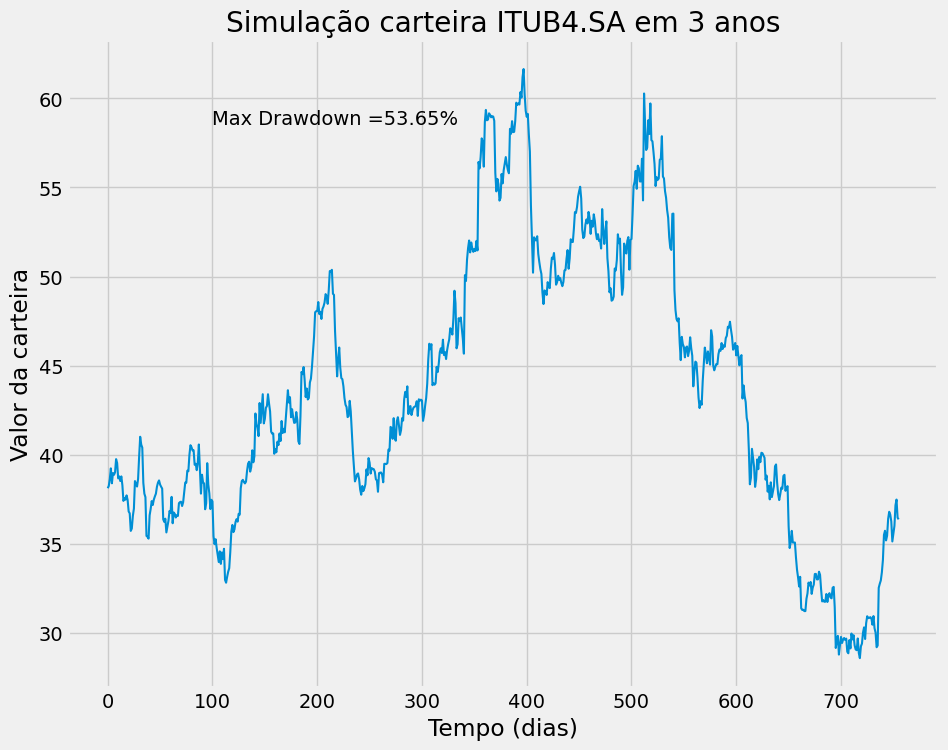

In [20]:
# Visualização da simulação do valor da carteira

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(sim_val, linewidth = 1.5)
    plt.xlabel("Tempo (dias)")
    plt.ylabel("Valor da carteira")
    plt.annotate("Max Drawdown =" + str(round(max_dd*100, 2)) + "%", (100, np.max(sim_val)*0.95))
    plt.title("Simulação carteira " + ticker + " em " + str(anos) + " anos")
    plt.show();

In [21]:
# Vamos ao Monte Carlo com X simulações 

num_sim = 100000

dd = np.array([])

for n in range(num_sim): # basta colocar a lógica anterior dentro de um laço for
    # Simula os retornos diários dos próximos 3 anos
    sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

    # Faz o cálculo do valor da carteira com retorno composto
    sim_val = ultimo_preco*(1 + sim_ret).cumprod()

    # Calcula o valor máximo da carteira simulada
    max_val = np.maximum.accumulate(sim_val)

    # Encontra o drawdown máximo
    max_dd = np.max((max_val - sim_val)/max_val)
    dd = np.append(dd, max_dd)

In [22]:
dd

array([0.33097164, 0.69237624, 0.39236653, ..., 0.5395264 , 0.49923558,
       0.35332245])

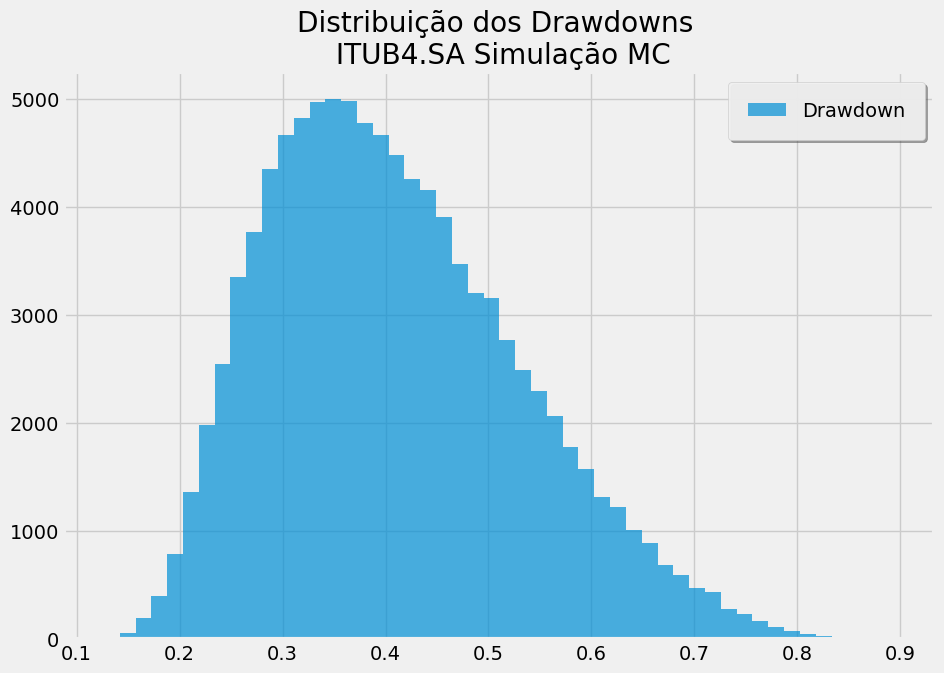

In [23]:
# Vamos visualizar a distribuição dos drawdowns

config = dict(histtype = "stepfilled", alpha = 0.7, density = False, bins = 50)

plt.figure(figsize = (10,7))
plt.hist(dd, **config, label = "Drawdown")

# Formataçao da legenda - Valida para qualquer tipo de grafico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Distribuição dos Drawdowns \n " + ticker + " Simulação MC")
plt.show();

In [24]:
# Por fim, as estatísticas importantes

print("Para o ativo " + ticker + " segundo uma simulação de Monte Carlo,")
print("com " + str(num_sim) + " simulações, em " + str(anos) + " anos podemos esperar:")
print()
print("---------------------------------------------------------")
print("Drawdown médio " + str(round(np.mean(dd*100), 2)) + "%")
print()
print("Com: ")
print("    50% de probabilidade, o DD será maior do que " + str(round(np.median(dd*100), 2)) + "%")
print("    25% de probabilidade, o DD será maior do que " + str(round(np.percentile(dd*100, 75), 2)) + "%")
print("     5% de probabilidade, o DD será maior do que " + str(round(np.percentile(dd*100, 95), 2)) + "%")
print("---------------------------------------------------------")
print()
print("Período dos parâmetros para a simulação: " + inicio  + " à " + fim)

Para o ativo ITUB4.SA segundo uma simulação de Monte Carlo,
com 100000 simulações, em 3 anos podemos esperar:

---------------------------------------------------------
Drawdown médio 40.91%

Com: 
    50% de probabilidade, o DD será maior do que 39.39%
    25% de probabilidade, o DD será maior do que 48.9%
     5% de probabilidade, o DD será maior do que 63.45%
---------------------------------------------------------

Período dos parâmetros para a simulação: 2010-01-01 à 2025-05-30


Quanto voce pode ter alocado em uma carteira e perder

O problema da simulação de monte carlo é que ela admite que os dados pertencem a uma distribuição normal